# GNN Introduction

In `01_intro_to_graphs`, the topic of Graph Neural Networks (GNN) was briefly introduced.
In this notebook, we will dive a little bit deeper into the topic of GNNs.

## Table of Contents
1. [Introduction to Graph Neural Networks (GNNs)](#introduction-to-graph-neural-networks-gnns)
2. [How do GNNs work?](#how-do-gnns-work)
3. [Simple GNN Example using Numpy](#simple-gnn-example-using-numpy)
4. [Visualizing Graph Topology using `networkx`](#visualizing-graph-topology-using-networkx)
5. [Popular GNN Models](#popular-gnn-models)
6. [Reference Papers](#reference-papers)

In [1]:
# Uncomment the following line if running in Google Colab
# !pip install numpy matplotlib networkx pandas scikit-learn

## Introduction to Graph Neural Networks (GNNs) <a name="introduction-to-graph-neural-networks-gnns"></a>

Graph Neural Networks (GNNs) have emerged as a potent tool to tackle machine learning problems on graph data.
Unlike conventional neural networks, which are designed for grid-like structured data (e.g., images and sequences), GNNs operate over nodes and edges of graphs.

Since graph is a super-set of many other data structures, GNNs can be applied to a wide variety of applications, such as social network analysis, recommender systems, knowledge graphs, and molecular chemistry.
In other words, it is possible to apply GNNs to any data that can be represented as a graph, and the critical challenge is to design a GNN architecture that is suitable for the given task/data.

### Tabular Data -> Graph Data
- Rows can represent nodes.
- Relationships (if any) between rows can represent edges.

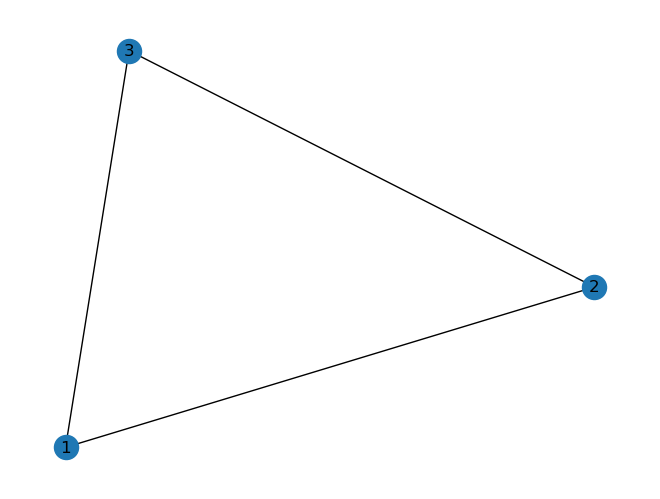

In [2]:
import networkx as nx
import pandas as pd

# Assuming a DataFrame df with columns 'id', 'attribute', 'related_id'
df = pd.DataFrame({
    'id': [1, 2, 3],
    'attribute': ['A', 'B', 'C'],
    'related_id': [3, 1, 2]
})

G_tabular = nx.from_pandas_edgelist(df, 'id', 'related_id')

# View the graph
nx.draw(G_tabular, with_labels=True)

### Text Data -> Graph Data

- Words or sentences can be nodes.
- Co-occurrence or semantic similarity can be edges.

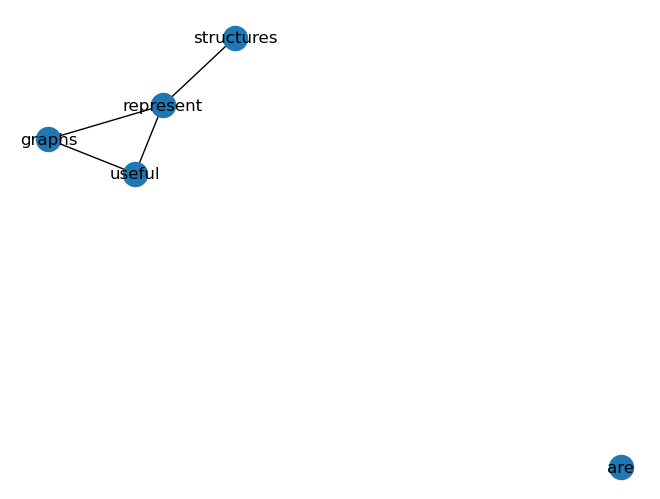

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

text = "Graphs are useful. Graphs represent structures."

vectorizer = CountVectorizer(ngram_range=(1,1))
X = vectorizer.fit_transform([text])
words = vectorizer.get_feature_names_out()

G_text = nx.Graph()
for word in words:
    G_text.add_node(word)

# Add edges based on co-occurrence or other criteria.
G_text.add_edge('graphs', 'useful')
G_text.add_edge('graphs', 'represent')
G_text.add_edge('useful', 'represent')
G_text.add_edge('represent', 'structures')

# View the graph
nx.draw(G_text, with_labels=True)

### Image Data -> Graph Data
- Pixels or regions can be nodes.
- Spatial adjacency or similarity can be edges.

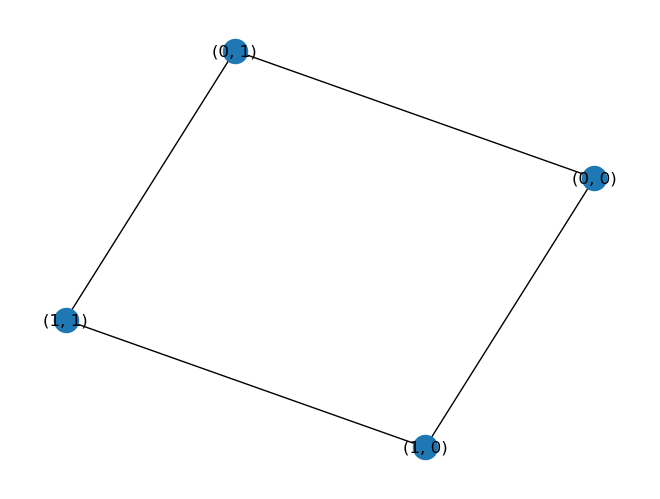

In [4]:
import numpy as np

# Assuming a 2x2 grayscale image for simplicity
image = np.array([[255, 128], [64, 32]])

G_image = nx.Graph()
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        G_image.add_node((i,j), intensity=image[i,j])

# Add edges based on spatial adjacency.
G_image.add_edge((0,0), (0,1))
G_image.add_edge((0,0), (1,0))
G_image.add_edge((0,1), (1,1))
G_image.add_edge((1,0), (1,1))

# View the graph
nx.draw(G_image, with_labels=True)

### Time Series Data -> Graph Data
- Time stamps can be nodes.
- Temporal adjacency or other relationships can be edges.

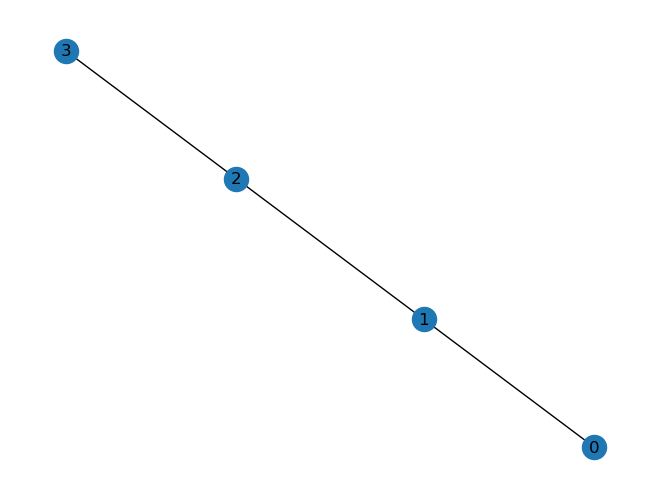

In [5]:
time_series = [1, 2, 3, 4]

G_time = nx.Graph()
for idx, value in enumerate(time_series):
    G_time.add_node(idx, value=value)

# Add edges based on temporal adjacency.
G_time.add_edge(0, 1)
G_time.add_edge(1, 2)
G_time.add_edge(2, 3)

# View the graph
nx.draw(G_time, with_labels=True)

## How do GNNs work? <a name="how-do-gnns-work"></a>

At the heart of every GNN model is a **message-passing** mechanism. Each node aggregates messages (information) from its neighbors and possibly itself. This aggregation procedure is repeated for several iterations or 'hops'.

**General Procedure:**

1. **Node feature initialization**: Each node is represented by a feature vector. This can be initialized from node attributes or set to a default value if no attributes are available.

2. **Message passing**: Each node aggregates the features from its neighbors. Aggregation can be a sum, mean, or even more complicated functions.

3. **Node update**: After aggregating messages, nodes update their features.

This process continues for a defined number of iterations or until convergence.

In [6]:
import numpy as np

# Create a simple graph with an adjacency matrix.
# The graph is: 0--1--2--3
adj_matrix = np.array([[0, 1, 0, 0],
                       [1, 0, 1, 0],
                       [0, 1, 0, 1],
                       [0, 0, 1, 0]])

# Assign random features for each node
node_features = np.array([[1, 0.5],
                          [0.5, 1.5],
                          [1.5, 0.5],
                          [0, 1]])

# Normalize the adjacency matrix with self-loops
norm_adj_matrix = adj_matrix + np.eye(adj_matrix.shape[0])

# Step 1: Aggregate
# Multiply normalized adjacency matrix with node features for aggregation
aggregated_features = np.dot(norm_adj_matrix, node_features)

# Step 2: Combine
# Here, we simply add the aggregated features to the original node features
updated_features = node_features + aggregated_features

print(updated_features)

[[2.5 2.5]
 [3.5 4. ]
 [3.5 3.5]
 [1.5 2.5]]


The example above is using a simple `sum` as the aggregation function, and it allows us to use simple matrix multiplication to implement the message passing mechanism.
In practice, more complicated aggregation functions can be used, and the message passing mechanism can be implemented using more sophisticated techniques, such as attention mechanism or graph convolution.

## Simple GNN Example using Numpy <a name="simple-gnn-example-using-numpy"></a>

For simplicity, consider a graph with three nodes $A$, $B$, and $C$ connected linearly: $A \rightarrow B \rightarrow C$. 

Let's initialize the node features using random values and propagate information for one iteration.

In [7]:
# Initialize node features
node_features = {
    'A': np.array([0.5, -0.5]),
    'B': np.array([-0.3, 0.3]),
    'C': np.array([0.1, -0.1])
}

# Edges (with optional weights)
edges = {
    'A': {'B': 0.8},
    'B': {'A': 0.8, 'C': 0.9},
    'C': {'B': 0.9}
}

# Message passing (sum aggregation for simplicity)
new_features = {}
for node, neighbors in edges.items():
    aggregated_messages = node_features[node]  # Initialize with own features
    for neighbor, weight in neighbors.items():
        aggregated_messages += node_features[neighbor] * weight
    new_features[node] = aggregated_messages

print(new_features)

{'A': array([ 0.26, -0.26]), 'B': array([-0.002,  0.002]), 'C': array([ 0.0982, -0.0982])}


## Popular GNN Models <a name="popular-gnn-models"></a>

### GraphSAGE (Graph Sample and Aggregation)

GraphSAGE introduces a method to inductively learn embeddings by leveraging node feature information. It samples a fixed-size neighborhood around each node and applies aggregation functions (mean, LSTM, pooling) to propagate information.

### GCN (Graph Convolutional Network)

GCN is a foundational model in the GNN universe. It aggregates neighbor information by taking a weighted average of the neighbor features. With multi-layer GCNs, information can be propagated from distant nodes.

### ChebNet (Spectral Graph ConvNets)

ChebNet operates in the spectral domain using the graph Laplacian's eigenvectors. It leverages Chebyshev polynomial to approximate spectral graph convolutions.

---

**Reference Papers:**

1. Hamilton, W., Ying, R., & Leskovec, J. (2017). [Inductive representation learning on large graphs](https://arxiv.org/abs/1706.02216). In NeurIPS.

2. Kipf, T. N., & Welling, M. (2017). [Semi-supervised classification with graph convolutional networks](https://arxiv.org/abs/1609.02907). In ICLR.

3. Defferrard, M., Bresson, X., & Vandergheynst, P. (2016). [Convolutional neural networks on graphs with fast localized spectral filtering](https://arxiv.org/abs/1606.09375). In NeurIPS.


There are many more GNN models coming out every year, and it is impossible to cover all of them in this notebook.
However, the basic idea behind all of them is the same: **message passing**.